&nbsp;

# 3. Feature Engineering
Feature engineering is the process of selecting, manipulating, and transforming raw data into features that can be used in supervised learning. Feature engineering is one of the most important steps when it comes to a machine learning project because algorithms can only interpret data in a certain way (numerical). For example, categorical data must be binary encoded for it to be considered during the fitting process. Furthermore, there could be features that disrupt the correlation between the label and other features, so removing them is just as important. 

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt;
import os
%matplotlib inline 
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Importing emsemble models. 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Import functions py file. 
import functions
import plot_functions

# Import transformers. 
from sklearn.preprocessing import FunctionTransformer, StandardScaler, Normalizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Converts plotly output into static images, so it can be viewed inside github repository. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Setting root directory as cwd. 
df = pd.read_csv(r"{}\train.csv".format(root)) # Importing the train set.
df.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.78570,20.0,3.97,0,0.647,7.014,84.6,2.1329,5,264.0,13.0,384.07,14.79,30.7
1,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4


&nbsp;

### Section A: Data Preparation
In this section we'll focus on improving the quality of our data by revising the price cap topic we discovered in the previous script. But before we explore that topic, we must first set up our benchmarks.

**A.1: Benchmarks** <br>
The first step is to set up our benchmarks, so we have a point of reference against which things may be compared. This is a very important step whenever conducting empirical testing. ML algorithms are stochastic in nature, which means not every prediction will be the same. So, it's a good idea to run some predictions n number of times then average out the score to record your loss metric.

In [3]:
# Storing results inside list. 
baseGBRscore= list()

# Running predictions through 5 iterations and recording the average score as the final MSE. 
for i in range(1,6):
    GBR = functions.model_evaluation() # Creating class instance. 
    GBR.preprocessing(df) # Transforming the data (imputing/encoding).
    GBR.add_pipe_component("clf", GradientBoostingRegressor()) # Adding model into pipeline. 
    GBR.cross_validation(df) # Evalauting our model performance through cross validation.  
    baseGBRscore.append(GBR.cv_result) # Appending result into list. 

In [4]:
baseRFRscore= list()

for i in range(1,6):
    RFR = functions.model_evaluation()
    RFR.preprocessing(df)
    RFR.add_pipe_component("clf", RandomForestRegressor())
    RFR.cross_validation(df)
    baseRFRscore.append(RFR.cv_result)

In [5]:
baseXGBscore= list()

for i in range(1,6):
    XGB = functions.model_evaluation()
    XGB.preprocessing(df)
    XGB.add_pipe_component("clf", XGBRegressor())
    XGB.cross_validation(df)
    baseXGBscore.append(XGB.cv_result)

In [6]:
# Setting up benchmarks. 
benchmarkGBR = {"Base_GBR" : np.mean(baseGBRscore)}
benchmarkRFR = {"Base_RFR" : np.mean(baseRFRscore)}
benchmarkXGB = {"Base_XGB" : np.mean(baseXGBscore)}

| Model | Model Type | Benchmark |
|---------|---------|---------|
| **Gradient Boosting Regressor** | Base Model | 9.26 |
| **Random Forest Regressor** | Base Model | 10.81 |
| **XGB Regressor** | Base Model | 10.69 |

**A.2: Price Cap** <br>
As mentioned in the previous section, through our statiscal summary we noticed a price cap of 50 set in our dependant variable (MEDV). It's important to deal with this as it can harm the correlation between our features and label. We can see the issue visually by plotting a scatterplot with our label against a random chosen feature.

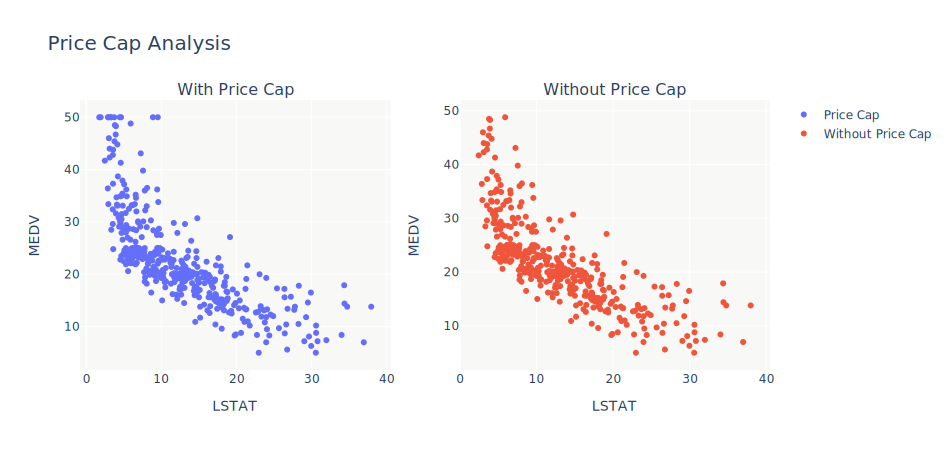

In [7]:
priceCapRemoval = df[df["MEDV"]!=50] # Filtering out points that =50. 

plot_functions.scatterplot_pricecap(df1=df, df2=priceCapRemoval)

* With the Price Cap scatterplot we can immediately see points start to disperse at coordinate y=50, breaking up the correlation. 
* By removing the Price Cap we can see a big improvement on the corrleation with points naturally following a linear relationship. 

**A.3: Testing our Hypothesis** <br>
We've seemed to have fixed our correlations, the next step is to test our hypothesis that the price cap was disrupting our model's performance. Let's now evaluate our regressor models using our newly filtered data.

In [8]:
# Storing results inside list. 
GBR_PriceCap_Score = list()

# Running predictions through 5 iterations and recording the average score as the final MSE. 
for i in range(1,6):
    GBR_PriceCap = functions.model_evaluation() # Creating class instance. 
    GBR_PriceCap.preprocessing(priceCapRemoval) # Transforming the data (imputing/encoding).
    GBR_PriceCap.add_pipe_component("clf", GradientBoostingRegressor()) # Adding model into pipeline. 
    GBR_PriceCap.cross_validation(priceCapRemoval) # Evalauting our model performance through cross validation.  
    GBR_PriceCap_Score.append(GBR_PriceCap.cv_result) # Appending result into list. 
    
# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(GBR_PriceCap_Score), benchmarkGBR, "GBR_PriceCap")

We reject the null hypothesis with the new benchmark for GBR_PriceCap: 8.0715


In [9]:
RFR_PriceCap_Score = list()

for i in range(1,6):
    RFR_PriceCap = functions.model_evaluation()
    RFR_PriceCap.preprocessing(priceCapRemoval)
    RFR_PriceCap.add_pipe_component("clf", RandomForestRegressor())
    RFR_PriceCap.cross_validation(priceCapRemoval)
    RFR_PriceCap_Score.append(RFR_PriceCap.cv_result)
    
# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(RFR_PriceCap_Score), benchmarkRFR, "RFR_PriceCap")

We reject the null hypothesis with the new benchmark for RFR_PriceCap: 9.0025


In [10]:
XGB_PriceCap_Score= list()

for i in range(1,6):
    XGB_PriceCap = functions.model_evaluation()
    XGB_PriceCap.preprocessing(priceCapRemoval)
    XGB_PriceCap.add_pipe_component("clf", XGBRegressor())
    XGB_PriceCap.cross_validation(priceCapRemoval)
    XGB_PriceCap_Score.append(XGB_PriceCap.cv_result)
    
# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(XGB_PriceCap_Score), benchmarkXGB, "XGB_PriceCap")

We reject the null hypothesis with the new benchmark for XGB_PriceCap: 8.2930


| Model | Model Type | Benchmark |
|---------|---------|---------|
| **Gradient Boosting Regressor** | PriceCap | 8.02 |
| **Random Forest Regressor** | PriceCap | 9.13 |
| **XGB Regressor** | PriceCap | 8.29 |

&nbsp;

### Section B: Data Transforms
Data Transformations are mathematical functions implemented into our dataset to change the general shape, scale and distribution of data. The objective is to transform the data into a more favourable format for our algorithm to ingest and boost performance.

**B.1: Log Transform** <br>
The log transform is a popular technique used to transform skewed data into a Gaussian distribution. The more symmetrical a distribution is the better "data behaves", and this is also true for machine learning algorithms, since they tend to perform better when the data is normally distributed.

In [11]:
log = FunctionTransformer(np.log1p) # Create a function transformer instance, with log as the argument. 
logDf = log.fit_transform(priceCapRemoval) # Fit and transform our imputed data. 
logDf.head(2) # Check to see results. 

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.579810,3.044522,1.60342,0.0,0.498955,2.081190,4.449685,1.141959,1.791759,5.579730,2.639057,5.953425,2.759377,3.456317
1,0.060747,0.000000,2.55955,0.0,0.452985,2.027227,4.249923,1.246630,0.693147,5.613128,3.091042,5.973784,2.367436,3.152736


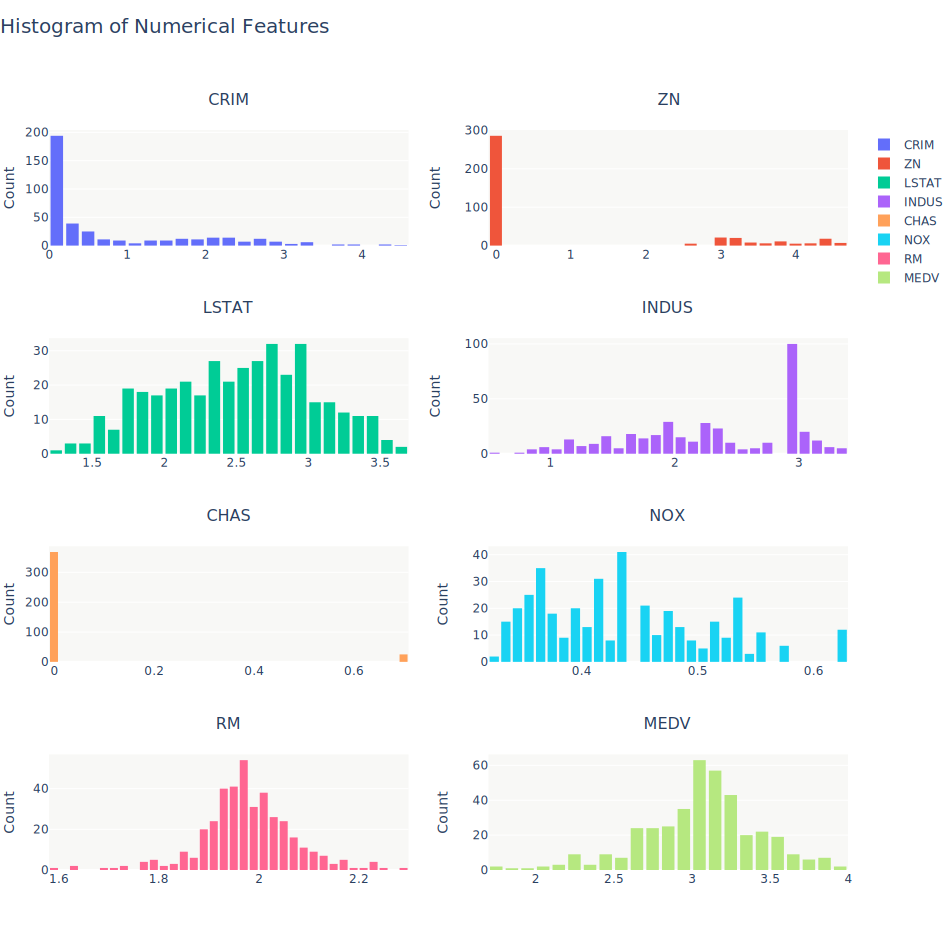

In [12]:
plot_functions.histogram(df=logDf)

* From the results we can see there are some general improvements on the distribution.

**A.4: Testing Hypothesis** <br>
The next step is to test the hypothesis that transforming our datasets scale into log will boost performance of our selected algorithms. Based on the results, we will compare the output against our base benchmarks.

In [13]:
GBR_PriceCap_Log_Score = list()

for i in range(1,6):
    GBR_PriceCap_Log = functions.model_evaluation()
    GBR_PriceCap_Log.preprocessing(priceCapRemoval)
    GBR_PriceCap_Log.add_pipe_component("log", FunctionTransformer(np.log1p)) # np.log cannot multiplie 0, so we use np.log1p. 
    GBR_PriceCap_Log.add_pipe_component("clf", GradientBoostingRegressor())
    GBR_PriceCap_Log.cross_validation(priceCapRemoval)
    GBR_PriceCap_Log_Score.append(GBR_PriceCap_Log.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(GBR_PriceCap_Log_Score), benchmarkGBR, "GBR_PriceCap_Log")

We accept the null hypothesis.


In [14]:
RFR_PriceCap_Log_Score = list()

for i in range(1,6):
    RFR_PriceCap_Log = functions.model_evaluation()
    RFR_PriceCap_Log.preprocessing(priceCapRemoval)
    RFR_PriceCap_Log.add_pipe_component("log", FunctionTransformer(np.log1p)) # np.log cannot multiplie 0, so we use np.log1p. 
    RFR_PriceCap_Log.add_pipe_component("clf", RandomForestRegressor())
    RFR_PriceCap_Log.cross_validation(priceCapRemoval)
    RFR_PriceCap_Log_Score.append(RFR_PriceCap_Log.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(RFR_PriceCap_Log_Score), benchmarkRFR, "RFR_PriceCap_Log")

We reject the null hypothesis with the new benchmark for RFR_PriceCap_Log: 8.9903


In [15]:
XGB_PriceCap_Log_Score = list()

for i in range(1,6):
    XGB_PriceCap_Log = functions.model_evaluation()
    XGB_PriceCap_Log.preprocessing(priceCapRemoval)
    XGB_PriceCap_Log.add_pipe_component("log", FunctionTransformer(np.log1p)) # np.log cannot multiplie 0, so we use np.log1p. 
    XGB_PriceCap_Log.add_pipe_component("clf", XGBRegressor())
    XGB_PriceCap_Log.cross_validation(priceCapRemoval)
    XGB_PriceCap_Log_Score.append(XGB_PriceCap_Log.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(XGB_PriceCap_Log_Score), benchmarkXGB, "XGB_PriceCap_Log")

We reject the null hypothesis with the new benchmark for XGB_PriceCap_Log: 8.2782


| Model | Model Type | Benchmark |
|---------|---------|---------|
| **Gradient Boosting Regressor** | PriceCap | 8.02 |
| **Random Forest Regressor** | PriceCap_Log | 9.10 |
| **XGB Regressor** | PriceCap_Log | 8.28 |

**A.5: Standardization** <br>
Now it's time to test out standardizing our dataset. Standardization converts the mean to 0 and a standard deviation of 1. Usually this transform is conducted on Gaussian distributions. Standardizing your dataset can potentially lead you to an uplift in performance.

In [16]:
GBR_PriceCap_S_Score = list()

for i in range(1,6):
    GBR_PriceCap_S = functions.model_evaluation()
    GBR_PriceCap_S.preprocessing(priceCapRemoval)
    GBR_PriceCap_S.add_pipe_component("s", StandardScaler())
    GBR_PriceCap_S.add_pipe_component("clf", GradientBoostingRegressor())
    GBR_PriceCap_S.cross_validation(priceCapRemoval)
    GBR_PriceCap_S_Score.append(GBR_PriceCap_S.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(GBR_PriceCap_S_Score), benchmarkGBR, "GBR_PriceCap_Standardized")

We reject the null hypothesis with the new benchmark for GBR_PriceCap_Standardized: 8.0518


In [17]:
RFR_PriceCap_S_Score = list()

for i in range(1,6):
    RFR_PriceCap_S = functions.model_evaluation()
    RFR_PriceCap_S.preprocessing(priceCapRemoval)
    RFR_PriceCap_S.add_pipe_component("s", StandardScaler())
    RFR_PriceCap_S.add_pipe_component("clf", RandomForestRegressor())
    RFR_PriceCap_S.cross_validation(priceCapRemoval)
    RFR_PriceCap_S_Score.append(RFR_PriceCap_S.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(RFR_PriceCap_S_Score), benchmarkRFR, "RFR_PriceCap_Standardized")

We accept the null hypothesis.


In [18]:
XGB_PriceCap_S_Score = list()

for i in range(1,6):
    XGB_PriceCap_S = functions.model_evaluation()
    XGB_PriceCap_S.preprocessing(priceCapRemoval)
    XGB_PriceCap_S.add_pipe_component("s", StandardScaler()) 
    XGB_PriceCap_S.add_pipe_component("clf", XGBRegressor())
    XGB_PriceCap_S.cross_validation(priceCapRemoval)
    XGB_PriceCap_S_Score.append(XGB_PriceCap_S.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(XGB_PriceCap_S_Score), benchmarkXGB, "XGB_PriceCap_Standardized")

We accept the null hypothesis.


| Model | Model Type | Benchmark |
|---------|---------|---------|
| **Gradient Boosting Regressor** | PriceCap | 8.02 |
| **Random Forest Regressor** | PriceCap_Log | 9.10 |
| **XGB Regressor** | PriceCap_Log | 8.28 |

**A.6: Normalization** <br>
Normalization is the process of rescaling the dataset to the range of 0 to 1.

In [19]:
GBR_PriceCap_N_Score = list()

for i in range(1,6):
    GBR_PriceCap_N = functions.model_evaluation()
    GBR_PriceCap_N.preprocessing(priceCapRemoval)
    GBR_PriceCap_N.add_pipe_component("n", Normalizer())  
    GBR_PriceCap_N.add_pipe_component("clf", GradientBoostingRegressor())
    GBR_PriceCap_N.cross_validation(priceCapRemoval)
    GBR_PriceCap_N_Score.append(GBR_PriceCap_N.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(GBR_PriceCap_N_Score), benchmarkGBR, "GBR_PriceCap_Normalized")

We accept the null hypothesis.


In [20]:
RFR_PriceCap_N_Score = list()

for i in range(1,6):
    RFR_PriceCap_N = functions.model_evaluation()
    RFR_PriceCap_N.preprocessing(priceCapRemoval)
    RFR_PriceCap_N.add_pipe_component("n", Normalizer()) 
    RFR_PriceCap_N.add_pipe_component("clf", RandomForestRegressor())
    RFR_PriceCap_N.cross_validation(priceCapRemoval)
    RFR_PriceCap_N_Score.append(RFR_PriceCap_N.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(RFR_PriceCap_N_Score), benchmarkRFR, "RFR_PriceCap_Normalized")

We accept the null hypothesis.


In [21]:
XGB_PriceCap_N_Score = list()

for i in range(1,6):
    XGB_PriceCap_N = functions.model_evaluation()
    XGB_PriceCap_N.preprocessing(priceCapRemoval)
    XGB_PriceCap_N.add_pipe_component("n", Normalizer()) 
    XGB_PriceCap_N.add_pipe_component("clf", XGBRegressor())
    XGB_PriceCap_N.cross_validation(priceCapRemoval)
    XGB_PriceCap_N_Score.append(XGB_PriceCap_N.cv_result)

# Our hypothesis is that a standardized dataset will boost model performance.  
functions.hypothesis_testing(np.mean(XGB_PriceCap_N_Score), benchmarkXGB, "XGB_PriceCap_Normalized")

We accept the null hypothesis.


| Model | Model Type | Benchmark |
|---------|---------|---------|
| **Gradient Boosting Regressor** | PriceCap | 8.02 |
| **Random Forest Regressor** | PriceCap_Log | 9.10 |
| **XGB Regressor** | PriceCap_Log | 8.28 |

&nbsp;

### Section B: Correlation Analysis
Correlation analysis is an important step to understanding the relationships with the underlying data and target variable. It is basically a feature elimination technique used to filter out those features that share a weak correlation (whether its positive or negative), and keep those that share a strong relationship with the labelled data.  

**B.1: Correlation Matrix** <br>
A correlation matrix is a table that displays the correlation between every possible variable. It's a useful visual to measure the correlation of each feature against the target variable.

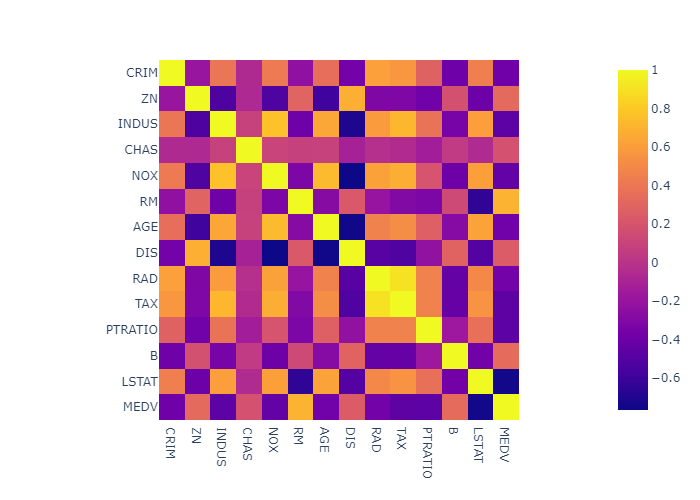

In [22]:
# Transforming our dataframe into pairwise correlation of all columns. 
corr = df.corr()
fig = px.imshow(corr) # Visualizing correlation through heatmap. 
fig.show(renderer="png") # Displaying heatmap. 

* From our correlation matrix there doesn't seem to be alot of features correlated with our label MEDV.
* LSTAT and RM seem to be the only features with at least a 70% correlation.

**B.2: Scatter Matrix** <br>
A scatter matrix is a matrix of scatterplots with each feature against the target variable. Just like a corrleation matrix, it is a measure of how strong a feature's relationship is with the label.

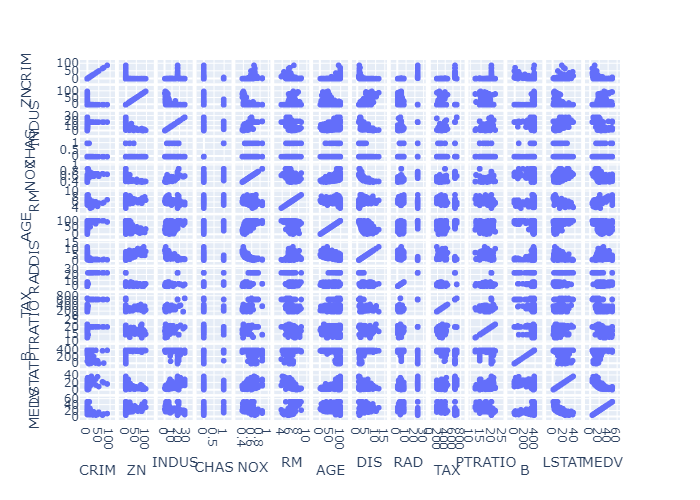

In [23]:
fig = px.scatter_matrix(df) # Plotting scatter matrix. 
fig.show(renderer="png") # Displaying visual.

&nbsp;

### Section C: Recursive Feature Elimination
In this section we'll be focusing on Feature Elimination using scikit-learn's Recrusive Feature Elimination. RFE is a feature elimination technqiue which aims to find the most important features when it comes to predicting our labels. It works through our entire feature space, recursively considering smaller and smaller sets of features. Through each iteration it assigns weights to features (e.g., the feature_importance_ attribute in any classification estimator) and uses this metric to gauge how imporant each feature is at predicting the target variable. At the end of the process, only the most important features are kept.

**C.1: Implementing RFEV with Gradient Boosting Regressor** <br>
Now let's implement RFECV onto our base Gradient Boosting Regressor Model.

In [24]:
rfeGBR = functions.model_evaluation()
# arguments(data, model) 
rfeGBR.RFE_cross_validate(priceCapRemoval, GradientBoostingRegressor())
print("Optimal number of features: %d" % rfeGBR.rfe_result.n_features_)

# Store results into a dictionary. 
dictGBR = rfeGBR.rfe_result.cv_results_

Optimal number of features: 10


**C.2: Implementing RFEV with Random Forest Regressor** <br>
Now let's implement RFECV onto our base Random Forest Regressor Model.

In [25]:
rfeRFR = functions.model_evaluation()
# arguments(data, model) 
rfeRFR.RFE_cross_validate(priceCapRemoval, RandomForestRegressor())
print("Optimal number of features: %d" % rfeRFR.rfe_result.n_features_)

# Store results into a dictionary. 
dictRFR = rfeRFR.rfe_result.cv_results_

Optimal number of features: 7


**C.3: Implementing RFEV with XGB Regressor** <br>
Now let's implement RFECV onto our base XGB Regressor Model.

In [26]:
rfeXGB = functions.model_evaluation()
# arguments(data, model) 
rfeXGB.RFE_cross_validate(priceCapRemoval, XGBRegressor())
print("Optimal number of features: %d" % rfeXGB.rfe_result.n_features_)

# Store results into a dictionary. 
dictXGB = rfeXGB.rfe_result.cv_results_

Optimal number of features: 13


**C.4: Plotting the RFECV Output** <br>
Now let's plot the neg_mean_squared_error against the number of features for each algorithm to see at which point the optimal number of features were selected.

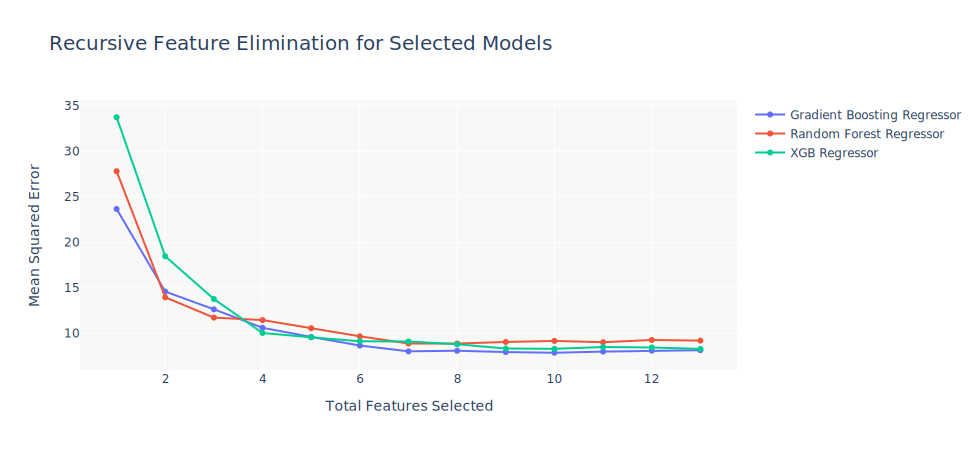

In [27]:
# Setting up axes values. 
x_axis = list(range(1, len(dictGBR['mean_test_score']) + 1)) # Maximum no. of features is 258.
y_axisGBR = abs(dictGBR['mean_test_score'])
y_axisRFR = abs(dictRFR['mean_test_score'])
y_axisXGB = abs(dictXGB['mean_test_score'])

plot_functions.plot_rfe(xaxis=x_axis, yGBR=y_axisGBR, yRFR=y_axisRFR, yXGB=y_axisXGB)

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  